In [19]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.colors as colors
import astropy.coordinates as coord
from stl import mesh
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

In [20]:
# 2/3D vec,tor classes with basic operations

class Vector2:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Vector2(self.x + other.x, self.y + other.y)
    
    def __sub__(self, other):
        return Vector2(self.x - other.x, self.y - other.y)
    
    def __mul__(self, other: float):
        return Vector2(self.x * other, self.y * other)
    
    def __truediv__(self, other: float):
        return Vector2(self.x / other, self.y / other)

    def to_vector3(self):
        return Vector3(self.x, self.y, 0)

class Vector3:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.array = np.array([self.x, self.y, self.z])

    def __add__(self, other):
        return Vector3(self.x + other.x, self.y + other.y, self.z + other.z)
    
    def __sub__(self, other):
        return Vector3(self.x - other.x, self.y - other.y, self.z - other.z)
    
    def __mul__(self, other):
        return Vector3(self.x * other, self.y * other, self.z * other)
    
    def __truediv__(self, other):
        return Vector3(self.x / other, self.y / other, self.z / other)

    def __repr__(self):
         return f"Vector3({self.x}, {self.y}, {self.z})"
         
    def rotate(self, t):
        tx, ty, tz = np.deg2rad(t.x), np.deg2rad(t.y), np.deg2rad(t.z)
        matrix_x = np.matrix([[1, 0, 0], [0, np.cos(tx), -np.sin(tx)], [0, np.sin(tx), np.cos(tx)]])
        matrix_y = np.matrix([[np.cos(ty), 0, np.sin(ty)], [0, 1, 0], [-np.sin(ty), 0, np.cos(ty)]])
        matrix_z = np.matrix([[np.cos(tz), -np.sin(tz), 0], [np.sin(tz), np.cos(tz), 0], [0, 0, 1]])
        res_x = self.array * matrix_x
        res_y = res_x * matrix_y
        res_z = res_y * matrix_z

        self.x, self.y, self.z = round(res_z[0, 0], 5), round(res_z[0, 1], 5), round(res_z[0, 2], 5)
        return self

In [21]:
# a workpiece is cylinder defined by its length and radius
class Workpiece:
    def __init__(self, length: int, radius: float):
        self.length = length
        self.radius = radius
        self.array = np.array([])
        for i in range(0, length):
            self.array = np.append(self.array, self.radius)
        self.array_uncut = self.array.copy()
        self.negative_array = [-i for i in self.array]
        self.negative_array_uncut = self.negative_array.copy()
    
    # sets the correct dimensions of the plot and plots the workpiece
    def visualize_half(self):
        """
        x = np.array([i for i in range(self.length)])
        b_spline_coeff = make_interp_spline(x, self.array)
        x_final = np.linspace(x.min(), x.max(), 500)
        y_final = b_spline_coeff(x_final)
        plt.plot(x_final, y_final)
        """
        g = fig.add_subplot(133)
        g.plot(self.array)
        g.set_xlim(0, self.length)
        g.set_ylim(-self.radius * 2, self.radius * 2)

    def visualize_uncut(self):
        g = fig.add_subplot(131)
        g.set_title("Uncut Workpiece")
        g.plot(self.array_uncut, color='orange')
        g.plot(self.negative_array_uncut, color='orange')
        g.set_xlim(0, self.length)
        g.set_ylim(-self.radius * 2, self.radius * 2)

    def visualize(self):
        self.negative_array = [-i for i in self.array]
        g = fig.add_subplot(133)
        g.set_title("Finished Workpiece")
        g.plot(self.array, color='orange')
        g.plot(self.negative_array, color='orange')
        g.set_xlim(0, self.length)
        g.set_ylim(-self.radius * 2, self.radius * 2)

    # point is the index of the slice, depth the y-coordinate of the cut
    def cut(self, point: int, depth: float):
        self.array[point] = depth

    # cut to the same depth at multiple points
    # points: (from: inclusive, to: exclusive)
    def cut_multiple(self, points: list[int, int], depth: float):
        for point in range(points[0], points[1] - 1):
            self.cut(point, depth)

In [22]:
# position is left top corner
# form is a list of tuples with float (depth) and int (how often) (index is x-coordinate, value is cut-depth)
# wp_lenght is the length of the workpiece, needed for correct plotting
class Tool:
    def __init__(self, position: Vector2, raw_form: np.array([Vector2]), wp_lenght: int):
        self.position = position
        self.wp_length = wp_lenght
        self.form_on_origin = np.array([])
        self.raw_form = self.interpolate(raw_form)
        self.form = self.calculate_form()
    
    def interpolate(self, raw_form):
        modified_raw_form = np.array([])
        x_coords2interp = np.array([i for i in range(self.wp_length)])
        x_coords = np.array([0])
        y_coords = np.array([0])

        for i, _ in enumerate(raw_form):
            x_coords = np.append(x_coords, raw_form[i].x)
            y_coords = np.append(y_coords, raw_form[i].y)
        x_coords = np.append(x_coords, self.wp_length)
        y_coords = np.append(y_coords, 0)

        modified_raw_form = -np.interp(x_coords2interp, x_coords, y_coords)
        return modified_raw_form
        
    def move(self, position: Vector2):
        self.position = position
        self.form = self.calculate_form()

    def calculate_form(self):
        local_form = self.raw_form.copy()
        for i in range(0, self.position.x): local_form = np.insert(local_form, 0, 0)
        for i, _ in enumerate(local_form): local_form[i] = self.position.y - local_form[i]
        while len(local_form) < self.wp_length: local_form = np.append(local_form, self.position.y)
        return local_form.copy()

    def visualize(self, wp):
        g = fig.add_subplot(132)
        g.set_title("Tool")
        self.plot = g.plot(self.form, color="blue")
        g.set_xlim(0, self.wp_length)
        g.set_ylim(-wp.radius * 2, wp.radius * 2)

    def cut(self, wp):
        for i, _ in enumerate(wp.array):
            wp.cut(i, min(self.form[i], wp.array[i]))


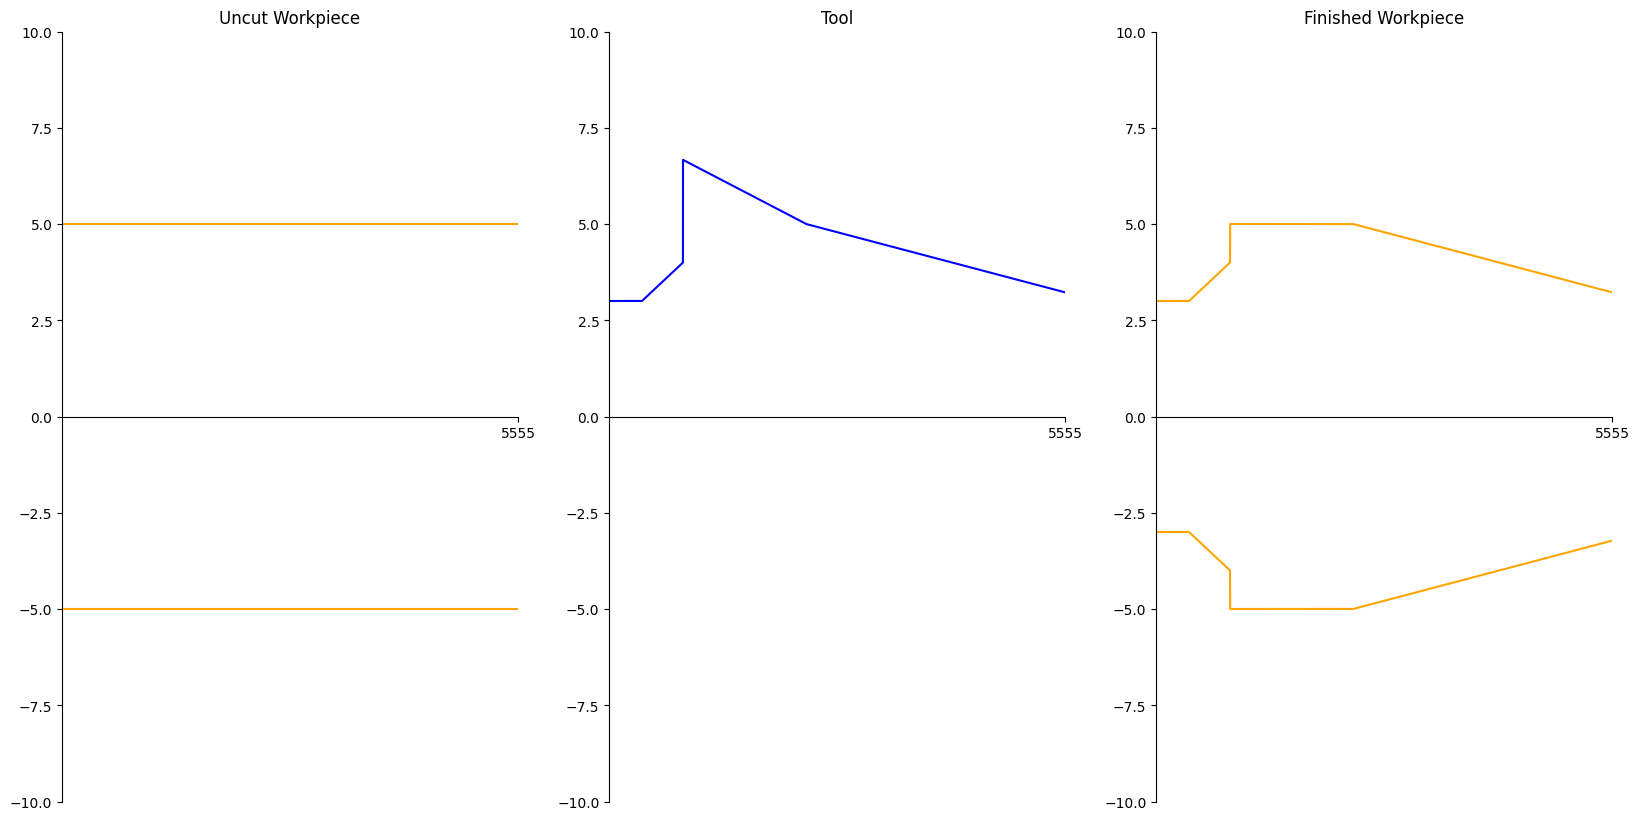

In [23]:
# intialize workpiece with length 9999, (this is the number of slices) and radius 5
wp = Workpiece(5555, 5)

# intialize the tool at the given position and set the shape
tl = Tool(Vector2(400, 3), np.array([Vector2(500, 1), Vector2(200, 4), Vector2(2000, 2)]), wp.length)



# visualize the tool
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
fig.tight_layout(pad=6)

tl.visualize(wp)
tl.cut(wp)

wp.visualize()
wp.visualize_uncut()

for ax in fig.get_axes():
    # set the x-spine
    ax.spines['left'].set_position('zero')

    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position('zero')

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
    ax.set_xticks([wp.length])
    ax.set_xticklabels([wp.length])


plt.show()

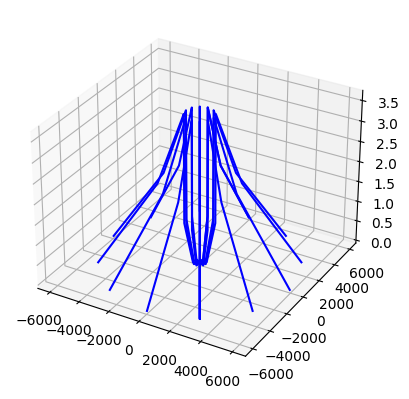

In [54]:
def create3d_plot():
    origin = Vector3(0, tl.form[0], 0)
    tl.form_on_origin = np.array([])
    x_coords_on_origin = np.array([])
    y_coords_on_origin = np.array([])
    z_coords_on_origin = np.array([])
    # the coordinates will get rounded and returned (x, y, z)
    output = np.array([[], [], []])
    ax = plt.axes(projection='3d')
    for i, _ in enumerate(tl.form):
        tl.form_on_origin = np.append(tl.form_on_origin, Vector3(i - origin.x, tl.form[i] - origin.y, 0))
    
    x_coords_on_origin = np.array([])
    y_coords_on_origin = np.array([])
    z_coords_on_origin = np.array([])
    for j in range(15, 375, 30):
        for k, _ in enumerate(tl.form_on_origin):
            tl.form_on_origin[k].rotate(Vector3(0, j, 0))
            x_coords_on_origin = np.append(x_coords_on_origin, np.array(tl.form_on_origin[k].z))
            y_coords_on_origin = np.append(y_coords_on_origin, np.array(tl.form_on_origin[k].x))
            z_coords_on_origin = np.append(z_coords_on_origin, np.array(tl.form_on_origin[k].y))
        
        ax.plot(x_coords_on_origin, y_coords_on_origin, z_coords_on_origin, color="blue")
        x_coords_on_origin = np.array([])
        y_coords_on_origin = np.array([])
        z_coords_on_origin = np.array([])
create3d_plot()
plt.show()